In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/serial-killers-dataset/Lessthan_5_victim_count.csv
/kaggle/input/serial-killers-dataset/5_to_14_victim_count.csv
/kaggle/input/serial-killers-dataset/15_to_30_victim_count.csv
/kaggle/input/serial-killers-dataset/Highest_victim_count.csv


**Objective:**

To analyze patterns and trends among serial killers based on victim count, demographic attributes, and behavioral factors, and to visualize insights that can help understand the characteristics, methods, and geographic distribution of serial crimes.

We can also break it down into specific goals:

1. Compare characteristics of killers across different victim count ranges.
2. Identify common methods, motives, and victim profiles.
3. Explore geographic trends and time periods of activity.
4. Visualize patterns to aid interpretation and insights.

## Import Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


In [56]:
import datetime

## Load data

In [57]:
lt5 = pd.read_csv("/kaggle/input/serial-killers-dataset/Lessthan_5_victim_count.csv")
v5_14 = pd.read_csv("/kaggle/input/serial-killers-dataset/5_to_14_victim_count.csv")
v15_30 = pd.read_csv("/kaggle/input/serial-killers-dataset/15_to_30_victim_count.csv")
highest = pd.read_csv("/kaggle/input/serial-killers-dataset/Highest_victim_count.csv")

In [58]:
lt5['victim_range'] = '<5'
v5_14['victim_range'] = '5-14'
v15_30['victim_range'] = '15-30'
highest['victim_range'] = '31+'

In [59]:
df = pd.concat([lt5, v5_14, v15_30, highest], ignore_index=True)

## Analyze data

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              305 non-null    object
 1   Country           305 non-null    object
 2   Years active      305 non-null    object
 3   Proven victims    305 non-null    object
 4   Possible victims  237 non-null    object
 5   Notes             305 non-null    object
 6   victim_range      305 non-null    object
dtypes: object(7)
memory usage: 16.8+ KB


In [61]:
df.head()

,Name,Country,Years active,Proven victims,Possible victims,Notes,victim_range
0,Charlie Brandt,United States,1971 to 2004,4,29,Committed suicide by hanging after murdering h...,<5
1,Robert Black,United Kingdom\r\nIreland (suspected)\r\nWest ...,1981 to 1986,4,18+,"Convicted of kidnapping, raping and murdering ...",<5
2,Max Gufler,Austria,1946 to 1958,4,18,"Poisoned and drowned four women, but suspected...",<5
3,Ernesto Picchioni,Italy,1949 and earlier,4,16,Murdered people who approached his home; died ...,<5
4,Baekuni,Indonesia,1993 to 2010,4,14,Pedophile who raped and killed young boys; ini...,<5


In [62]:
df.shape

(305, 7)

In [63]:
df.describe()

,Name,Country,Years active,Proven victims,Possible victims,Notes,victim_range
count,305,305,305,305,237,305,305
unique,305,74,260,55,108,305,4
top,Charlie Brandt,United States,1989 to 1990,11,16,Committed suicide by hanging after murdering h...,5-14
freq,1,92,3,24,11,1,164


## Preprocessing

In [64]:
df.isnull().sum()

Name                 0
Country              0
Years active         0
Proven victims       0
Possible victims    68
Notes                0
victim_range         0
dtype: int64

In [65]:
df['Possible victims'].fillna(0, inplace=True)

df.isnull().sum()

Name                0
Country             0
Years active        0
Proven victims      0
Possible victims    0
Notes               0
victim_range        0
dtype: int64

In [66]:
current_year = datetime.datetime.now().year

def parse_years_active(yrs):
    yrs = str(yrs).lower().strip()
    
    # Standard "YYYY to YYYY"
    if 'to' in yrs:
        parts = yrs.split('to')
        start = parts[0].strip()
        end = parts[1].strip()
        start_year = pd.to_numeric(start, errors='coerce')
        end_year = pd.to_numeric(end, errors='coerce')
        
    # "and earlier" → unknown start
    elif 'earlier' in yrs:
        end_year = pd.to_numeric(yrs.split('and')[0].strip(), errors='coerce')
        start_year = pd.NA  
    
    # "present" → replace with current year
    elif 'present' in yrs:
        start_year = pd.to_numeric(yrs.split()[0], errors='coerce')
        end_year = current_year
    
    else:
        start_year = pd.to_numeric(yrs, errors='coerce')
        end_year = start_year
    
    return pd.Series([start_year, end_year])

# Apply the function
df[['start_year', 'end_year']] = df['Years active'].apply(parse_years_active)

# Convert to nullable integer type to avoid .0
df['start_year'] = df['start_year'].astype('Int64')
df['end_year'] = df['end_year'].astype('Int64')

# Check result
df[['Years active', 'start_year', 'end_year']].head()

,Years active,start_year,end_year
0,1971 to 2004,1971,2004
1,1981 to 1986,1981,1986
2,1946 to 1958,1946,1958
3,1949 and earlier,<NA>,1949
4,1993 to 2010,1993,2010


In [67]:
df.columns

Index(['Name', 'Country', 'Years active', 'Proven victims', 'Possible victims',
       'Notes', 'victim_range', 'start_year', 'end_year'],
      dtype='object')

In [68]:
df.head()

,Name,Country,Years active,Proven victims,Possible victims,Notes,victim_range,start_year,end_year
0,Charlie Brandt,United States,1971 to 2004,4,29,Committed suicide by hanging after murdering h...,<5,1971,2004
1,Robert Black,United Kingdom\r\nIreland (suspected)\r\nWest ...,1981 to 1986,4,18+,"Convicted of kidnapping, raping and murdering ...",<5,1981,1986
2,Max Gufler,Austria,1946 to 1958,4,18,"Poisoned and drowned four women, but suspected...",<5,1946,1958
3,Ernesto Picchioni,Italy,1949 and earlier,4,16,Murdered people who approached his home; died ...,<5,<NA>,1949
4,Baekuni,Indonesia,1993 to 2010,4,14,Pedophile who raped and killed young boys; ini...,<5,1993,2010


## Visualize

In [91]:
earliest_start = df['start_year'].min()
latest_end = df['end_year'].max()

print("Earliest start year:", earliest_start)
print("Latest end year:", latest_end)


Earliest start year: 1880
Latest end year: 2018


---

### Top 10 Countries with the Highest Number of Killers

In [69]:
country_killer = df.groupby('Country',as_index=False)['Name'].count().sort_values(
    'Name',ascending = False).reset_index(col_level = 1).head(10)

country_killer.drop('index',axis=1,inplace=True)
country_killer.rename(columns={'Name':"Number of Killers"},inplace=True)
country_killer

,Country,Number of Killers
0,United States,92
1,Russia,21
2,South Africa,19
3,Soviet Union,13
4,United Kingdom,12
5,India,10
6,China,9
7,Brazil,8
8,France,6
9,Italy,6


Why the United States Leads by a Large Margin
The consensus among experts is that the vast difference is primarily due to documentation, reporting, and law enforcement infrastructure, rather than simply a higher rate of actual serial murder.

-----

### Distribution of Serial Killers Start Years

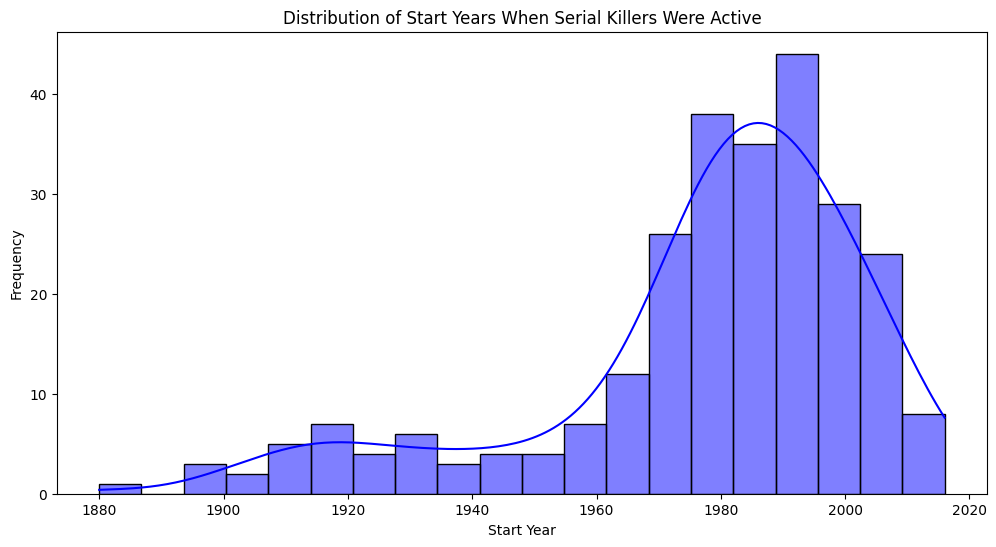

In [71]:
import re

def extract_years_range(years_active):
    years = re.findall(r'\d{4}', years_active)
    return (int(years[0]), int(years[1])) if len(years) == 2 else (np.nan, np.nan)

df[['Start Year', 'End Year']] = df['Years active'].apply(lambda x: pd.Series(extract_years_range(x)))
start_years = df['Start Year'].dropna()

# Plot distribution
plt.figure(figsize=(12, 6))
sns.histplot(start_years, bins=20, kde=True, color="blue")
plt.title("Distribution of Start Years When Serial Killers Were Active")
plt.xlabel("Start Year")
plt.ylabel("Frequency")
plt.show()

****

### Most Common Words in Serial Killer Notes

In [72]:
# Most Common Words in Serial Killer Notes

from collections import Counter

# Combine all notes into a single string
text = ' '.join(df['Notes'].dropna())

# Clean and tokenize the text (removing common stop words)
words = re.findall(r'\b\w+\b', text.lower())
stop_words = set(["the", "and", "of", "in", "to", "a", "for", "on", "with", "he", "was", "his", "that","as","by","them"])  # You can expand this list
filtered_words = [word for word in words if word not in stop_words]

# Count the words
word_counts = Counter(filtered_words)

# Convert most common words to a DataFrame
common_words_df = pd.DataFrame(word_counts.most_common(15), columns=["Word", "Frequency"])

# Display as a matrix
print(common_words_df)

         Word  Frequency
0      killed        147
1       known        134
2   sentenced        126
3     murders         99
4      killer         85
5       women         84
6     victims         80
7        life         79
8         who         73
9      people         70
10   murdered         69
11     prison         61
12  convicted         59
13   executed         59
14      years         57


Violent crimes, sentence focued on victims especially women, and freq.

### The most common methods or victim types.

In [90]:
import re
df['Notes_clean'] = df['Notes'].str.lower()

methods = ["strangle", "shoot", "stab", "poison", "rape", "children", "women"]

for m in methods:
    df[m] = df['Notes_clean'].str.contains(m).astype(int)

df[methods].sum().sort_values(ascending=False)


women       82
rape        45
strangle    32
children    28
poison      10
shoot        6
stab         6
dtype: int64

*  **Victim Demographics:** The data highlights that women (82) are the most frequently mentioned victim group, followed by children (28).

*  **Method of Killing:** Strangulation (32) is the most common method listed, significantly more frequent than poisoning (10), shooting (6), or stabbing (6).

*  **Motive/Associated Act:** The act of rape (45) is also a highly frequent category, suggesting it is a common element associated with the murders in this particular dataset.

****

### Timeline of Serial Killers Activity Periods

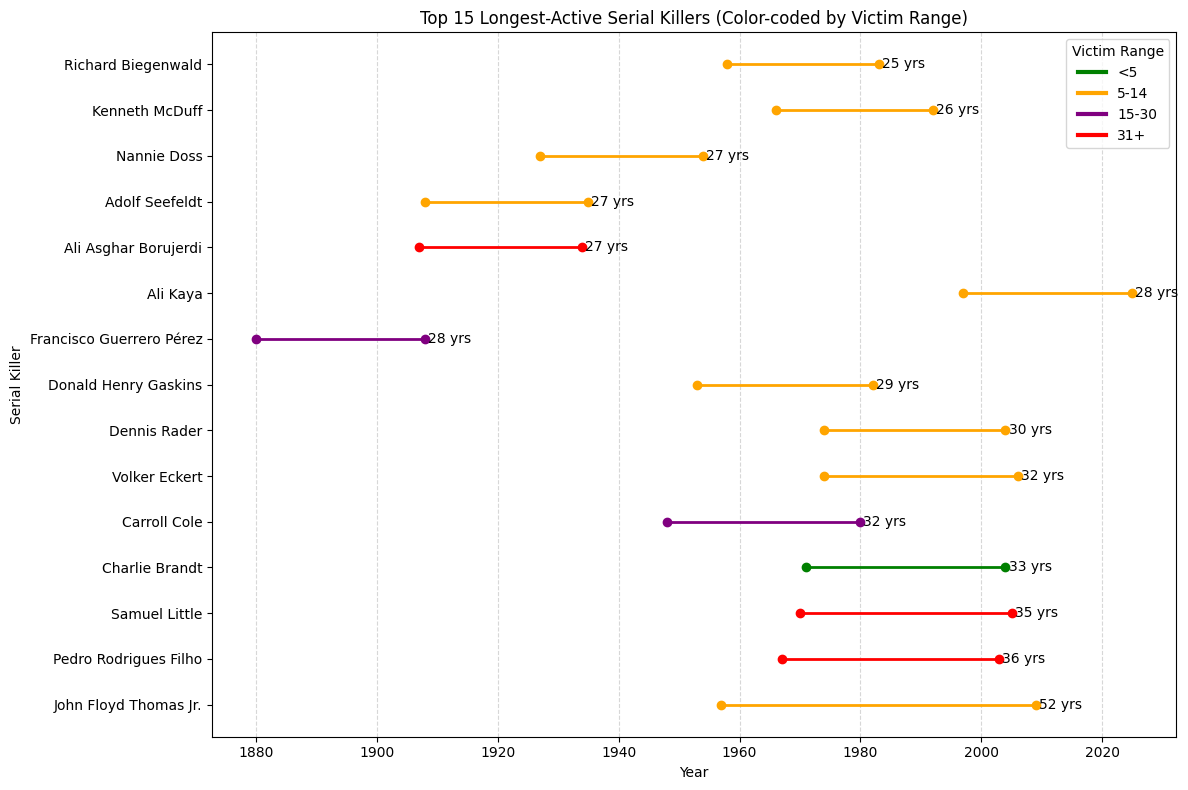

In [88]:
# Define colors for victim ranges
victim_colors = {
    '<5': 'green',
    '5-14': 'orange',
    '15-30': 'purple',
    '31+': 'red'
}

plt.figure(figsize=(12, 8))

for idx, row in top15.iterrows():
    color = victim_colors.get(row['victim_range'], 'gray')  # default gray if missing
    plt.plot([row['start_year_filled'], row['end_year']], [idx, idx],
             marker='o', markersize=6, linewidth=2, color=color)
    
    # Add duration text
    plt.text(row['end_year'] + 0.5, idx, f"{row['duration_years']} yrs", 
             verticalalignment='center', fontsize=10)

plt.yticks(range(len(top15)), top15['Name'])
plt.xlabel("Year")
plt.ylabel("Serial Killer")
plt.title("Top 15 Longest-Active Serial Killers (Color-coded by Victim Range)")
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=c, lw=3, label=label) for label, c in victim_colors.items()]
plt.legend(handles=legend_elements, title="Victim Range", loc='upper right')

plt.tight_layout()
plt.show()



* **Longest-Active Killer:** John Floyd Thomas Jr. has the longest recorded activity period at 52 years (Orange, 5-14 victims).

* **Most Victims (Longest Activity):** Pedro Rodrigues Filho and Samuel Little are listed with the longest activity periods (36 and 35 years, respectively) among those who had 31+ victims (Red).

* **Active in the Earliest Period:** Francisco Guerrero Pérez and Richard Biegenwald started their activity periods the earliest on the chart (around 1880 for Pérez and 1950s for Biegenwald).

* **Shortest Activity on the List:** Richard Biegenwald is listed with the shortest activity period at 25 years (Orange, 5-14 victims).

---

### Serial Killers' Activity Duration

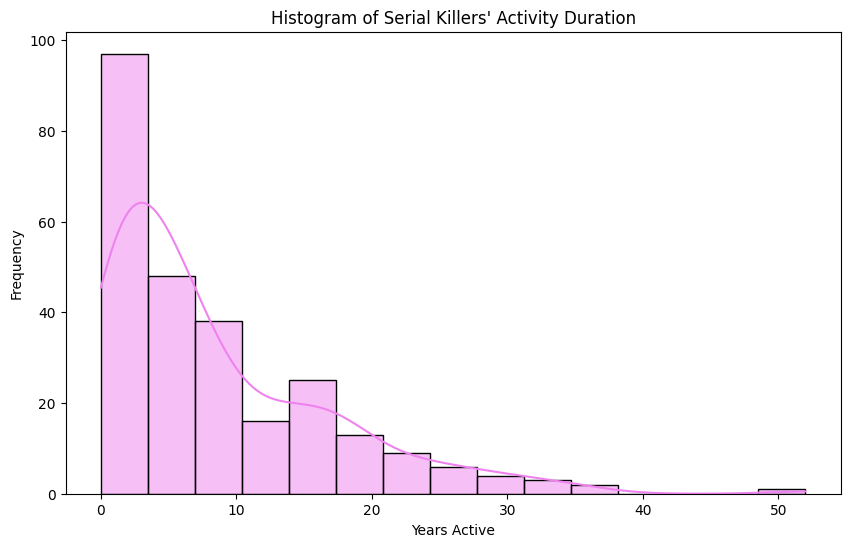

In [74]:
df['Activity Duration'] = df['End Year'] - df['Start Year']

plt.figure(figsize=(10, 6))
sns.histplot(df['Activity Duration'].dropna(), bins=15, color="violet", kde=True)
plt.title("Histogram of Serial Killers' Activity Duration")
plt.xlabel("Years Active")
plt.ylabel("Frequency")
plt.show()


* Most killers have short activity durations, often just a few years.

* A few killers have much longer durations, creating a long tail in the histogram.

---

Victim Range Distribution**

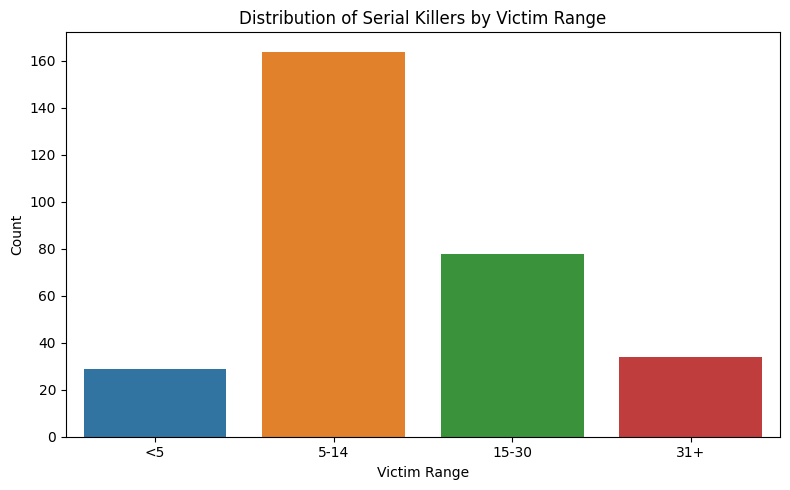

In [75]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='victim_range')
plt.title("Distribution of Serial Killers by Victim Range")
plt.xlabel("Victim Range")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


* **Most Common Range:** The most common victim range is 5-14 victims, which accounts for the largest group, with approximately 165 serial killers.

* **Second Most Common Range:** The second-largest category is 15-30 victims, with about 78 serial killers.

* **Least Common Range:** The range of <5 victims and the range of 31+ victims are the least common. The <5 victims group has about 30 killers, and the 31+ victims group has about 35 killers.

----

**Most persistent killers**

In [82]:
df[['Name', 'Activity Duration']].sort_values('Activity Duration', ascending=False).head(5)


,Name,Activity Duration
185,John Floyd Thomas Jr.,52.0
276,Pedro Rodrigues Filho,36.0
279,Samuel Little,35.0
0,Charlie Brandt,33.0
126,Volker Eckert,32.0


**Which killers stopped abruptly**

In [81]:
df[['Name', 'Activity Duration']].sort_values('Activity Duration').head(5)


,Name,Activity Duration
192,Sek Kim Wah,0.0
304,Radik Tagirov,1.0
198,Cedric Maake,1.0
208,Juan Fernando Hermosa,1.0
209,Earle Nelson,1.0


killers whose documented sprees lasted one year or less

-----

The most frequent words point to recurring themes in the data violent acts, legal consequences, long sentences, and a strong focus on victims especially women. This suggests the cases often involve severe crimes, heavy punishment, and clear victim patterns.